# Imports + Config

In [ ]:
import json
import requests
import pandas as pd
import numpy as np
#!pip install --upgrade typing_extensions
#!pip install pydantic
from pydantic import BaseModel
from typing import List
from typing import Union
import csv
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ollama Config
OLLAMA_NODE = "arctrdagn032"
BASE_URL = f"http://{OLLAMA_NODE}:11434/api/chat"

model = "gemma3-optimized:27b" # qwq:latest


#  Grabbing DAIC-WOZ data (Data Loader)

## Grabbing all participant IDs that have all the PHQ-8 questionare data

In [7]:
dev_split_phq8 = pd.read_csv(r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/dev_split_Depression_AVEC2017.csv")
train_split_phq8 = pd.read_csv(r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/train_split_Depression_AVEC2017.csv")

participant_ids = set()

# Grabbing unique participant ID values and putting them in a list

participant_ids.update(dev_split_phq8['Participant_ID'])
participant_ids.update(train_split_phq8['Participant_ID'])

participant_list = sorted(list(participant_ids))
# Did this cus execution loop kept breaking and I was too lazy to fix
values_already_done = {302, 303, 304, 305, 307, 310, 312, 313, 315, 316, 317, 318, 319, 320, 321, 322, 324, 325, 326, 327, 328, 330, 331, 333, 335, 336, 338, 339, 340, 341, 343, 344, 345, 346, 347, 348, 350, 351, 352, 353, 355, 356, 357, 358, 360, 362, 363, 364, 366, 367, 368, 369, 370, 371, 372, 374, 375, 376, 377, 379, 380, 381, 382, 383, 385, 386, 388, 389, 390, 391, 392, 393, 395, 397, 400, 401, 402, 403, 404, 406, 409, 412, 413, 414, 415, 416, 417, 418, 419, 420, 422, 423, 425, 426, 427, 428, 429, 430, 433, 434, 436, 437, 439, 440, 441, 443, 444, 445, 446, 447, 448, 449, 451, 454, 455, 456, 457, 458, 459, 463, 464, 468, 471, 472, 473}
for value in values_already_done:
    if value in participant_list:
        participant_list.remove(value)
print(participant_list)
print(dev_split_phq8)
print('\n\n\n')
print(train_split_phq8)
#participant_list = [310]
#print(participant_list)

[474, 475, 476, 477, 478, 479, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492]
    Participant_ID  PHQ8_Binary  PHQ8_Score  Gender  PHQ8_NoInterest  \
0              302            0           4       1                1   
1              307            0           4       0                0   
2              331            0           8       1                1   
3              335            1          12       0                1   
4              346            1          23       0                2   
5              367            1          19       1                3   
6              377            1          16       0                2   
7              381            1          16       1                2   
8              382            0           0       1                0   
9              388            1          17       1                1   
10             389            1          14       1                1   
11             390            0           9       

## Quantitative Assesment

In [ ]:
class PHQ8ScoreWithExplanation(BaseModel):
    evidence: str  # Direct quotes or references from interview
    reason: str  # Brief explanation for the score
    score: Union[int, str]  # 0-3 or "N/A"

class PHQ8ScoresWithExplanations(BaseModel):
    PHQ8_NoInterest: PHQ8ScoreWithExplanation  # Little interest or pleasure in doing things
    PHQ8_Depressed: PHQ8ScoreWithExplanation   # Feeling down, depressed, or hopeless
    PHQ8_Sleep: PHQ8ScoreWithExplanation       # Trouble falling/staying asleep, or sleeping too much
    PHQ8_Tired: PHQ8ScoreWithExplanation       # Feeling tired or having little energy
    PHQ8_Appetite: PHQ8ScoreWithExplanation    # Poor appetite or overeating
    PHQ8_Failure: PHQ8ScoreWithExplanation     # Feeling bad about self or like a failure
    PHQ8_Concentrating: PHQ8ScoreWithExplanation # Trouble concentrating
    PHQ8_Moving: PHQ8ScoreWithExplanation      # Moving/speaking slowly or being fidgety/restless

system_prompt = """You are a AI psychiatrist assessment tool specialized in analyzing interview transcripts to evaluate PHQ-8 (Patient Health Questionnaire-8) scores. The PHQ-8 is a validated depression screening instrument that assesses eight of the nine DSM-IV criteria for depressive disorders over the past 2 weeks.

PHQ-8 Scoring System:
- 0 = Not at all (0-1 days in the past 2 weeks)
- 1 = Several days (2-6 days)
- 2 = More than half the days (7-11 days)
- 3 = Nearly every day (12-14 days)

Key Principles:
1. Base all assessments strictly on evidence from the transcript
2. When no relevant evidence exists for a symptom, output "N/A" rather than assuming absence (score of 0)
3. Consider both explicit statements and behavioral indicators in the interview
4. Be conservative - only assign scores when there is clear evidence of frequency
5. Remember that absence of mention does not necessarily mean absence of symptom
6. Follow the format specified exactly"""

def run_phq8_analysis(patient_transcript, ground_truth):
    quantitative_prompt = f"""Analyze the following interview transcript and predict PHQ-8 scores for each symptom domain.

Interview transcript:
<transcript>
{patient_transcript}
</transcript>

Analyze each symptom using the following approach in <thinking> tags:
1. Search for direct quotes or behavioral evidence related to each PHQ-8 symptom
2. Evaluate the frequency/severity based on available evidence
3. If no relevant evidence exists, mark as "N/A" rather than assuming absence
4. Only assign numeric scores (0-3) when evidence clearly indicates frequency

After your analysis, provide your final assessment in <answer> tags as a JSON object.

For each symptom, provide:
1. "evidence": exact quotes from transcript (use "No relevant evidence found" if not discussed)
2. "reason": explanation of scoring decision, including why N/A if applicable
3. "score": integer 0-3 based on evidence, or "N/A" if no relevant evidence

Return ONLY a JSON object in <answer> tags with these exact keys:
- "nointerest": {{evidence, reason, score}} for little interest or pleasure in doing things (anhedonia)
- "depressed": {{evidence, reason, score}} for feeling down, depressed, or hopeless (depressed mood)
- "sleep": {{evidence, reason, score}} for trouble falling or staying asleep, or sleeping too much (sleep problems)
- "tired": {{evidence, reason, score}} for feeling tired or having little energy (fatigue)
- "appetite": {{evidence, reason, score}} for poor appetite or overeating (appetite/weight changes)
- "failure": {{evidence, reason, score}} for feeling bad about yourself or that you are a failure (negative self-perception)
- "concentrating": {{evidence, reason, score}} for trouble concentrating on things like reading or watching TV (concentration problems)
- "moving": {{evidence, reason, score}} for moving or speaking slowly, or being fidgety/restless (psychomotor changes)"""

    # Most deterministic temp, top_k, and top_p
    response = requests.post(
        BASE_URL,
        json={
            "model": model,
            "messages": [{"role": "system", "content": system_prompt},
                        {"role": "user", "content": quantitative_prompt}],
            "stream": False,
            "options": {
                "temperature": 0,
                "top_k": 1,
                "top_p": 1.0
            }
        }
    )

    # Parse and validate the response
    try:
        response_data = response.json()
        content = response_data['message']['content']
        
        # Extract content from <answer> tags if present
        if '<answer>' in content and '</answer>' in content:
            content = content.split('<answer>')[1].split('</answer>')[0].strip()
        
        # Remove markdown code blocks if present
        if content.startswith('```json'):
            content = content.split('```json')[1].split('```')[0].strip()
        elif content.startswith('```'):
            content = content.split('```')[1].split('```')[0].strip()
        
        # Parse the JSON response and validate with Pydantic
        scores_dict = json.loads(content)
        phq8_scores = PHQ8ScoresWithExplanations(**scores_dict)
        
        # Extract the 8 PHQ-8 score values
        scores_list = [
            phq8_scores.nointerest.score,
            phq8_scores.depressed.score,
            phq8_scores.sleep.score,
            phq8_scores.tired.score,
            phq8_scores.appetite.score,
            phq8_scores.failure.score,
            phq8_scores.concentrating.score,
            phq8_scores.moving.score
        ]
        
        print("Comparison of Predicted vs Ground Truth:")
        print("Metric\t\t\tPredicted\tGround Truth\tDifference")
        print("-" * 65)

        differences = []
        n_available = 0
        num_questions_NA = 0
        metrics = ['PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired', 
                'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving']
        predicted_values = [phq8_scores.nointerest.score, phq8_scores.depressed.score, phq8_scores.sleep.score, 
                        phq8_scores.tired.score, phq8_scores.appetite.score, phq8_scores.failure.score,
                        phq8_scores.concentrating.score, phq8_scores.moving.score]

        for metric, pred_val in zip(metrics, predicted_values):
            gt_val = int(ground_truth[metric])
            if pred_val == "N/A":
                diff_str = "N/A"
                num_questions_NA += 1
            else:
                diff = abs(pred_val - gt_val)
                differences.append(diff)
                diff_str = str(diff)
                n_available += 1
            print(f"{metric:<23} {str(pred_val):<12} {gt_val:<15} {diff_str}")

        # Calculate metrics
        if n_available > 0:
            avg_difference = sum(differences) / n_available
            accuracy_on_available = 1 - (avg_difference / 3)
        else:
            avg_difference = float('inf')
            accuracy_on_available = 0
        
        # Accuracy * % available questions
        overall_accuracy = accuracy_on_available * (1 - (num_questions_NA / 8))
        
        print("-" * 65)
        if n_available > 0:
            print(f"Average Absolute Difference (on available): {avg_difference:.2f}")
            print(f"Accuracy on available questions: {accuracy_on_available:.2%}")
        print(f"Questions marked N/A: {num_questions_NA}/8")
        print(f"Overall accuracy: {overall_accuracy:.2%}")
        
        # Reasoning and evidence section
        print("\n\nDetailed Reasoning for Each Score:")
        print("=" * 80)
        
        symptom_names = {
            'PHQ8_NoInterest': 'Little Interest/Pleasure',
            'PHQ8_Depressed': 'Feeling Depressed',
            'PHQ8_Sleep': 'Sleep Problems',
            'PHQ8_Tired': 'Fatigue',
            'PHQ8_Appetite': 'Appetite Changes',
            'PHQ8_Failure': 'Negative Self-Perception',
            'PHQ8_Concentrating': 'Concentration Problems',
            'PHQ8_Moving': 'Psychomotor Changes'
        }
        
        for key, symptom_name in symptom_names.items():
            score_data = getattr(phq8_scores, key)
            print(f"\n{symptom_name} (Score: {score_data.score})")
            print("-" * 40)
            print(f"Evidence: {score_data.evidence}")
            print(f"Reason: {score_data.reason}")

        return phq8_scores, avg_difference, accuracy_on_available, num_questions_NA, overall_accuracy

    except (json.JSONDecodeError, KeyError, ValueError) as e:
        print(f"Error parsing response: {e}")
        print("Raw response:", response)
        print(json.dumps(response.json(), indent=2))
        return None, None, None, None, None


## **Execution Loop (Slightly broken)**

In [ ]:
csv_file = f"/data/users2/agreene46/ai-psychiatrist/analysis_output/results.csv"
json_file = f"/data/users2/agreene46/ai-psychiatrist/analysis_output/results_detailed.jsonl"

# Initialize CSV file with headers
with open(csv_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['participant_id', 'timestamp', 'nointerest_score', 'depressed_score', 'sleep_score', 
                     'tired_score', 'appetite_score', 'failure_score', 'concentrating_score', 'moving_score',
                     'avg_difference', 'accuracy_on_available', 'num_questions_na', 'overall_accuracy'])

# Execution loop
for participant_id in participant_list:
    current_transcript = pd.read_csv(fr"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/{participant_id}_P/{participant_id}_TRANSCRIPT.csv", sep="\t")
    
    # Reformatting transcript data to be a string with speaker name + text
    current_patient_transcript = '\n'.join(current_transcript['speaker'] + ': ' + current_transcript['value'])
    
    # Get ground truth data for participant
    if participant_id in train_split_phq8['Participant_ID'].values:
        ground_truth = train_split_phq8[train_split_phq8['Participant_ID'] == participant_id].iloc[0]
    else:
        ground_truth = dev_split_phq8[dev_split_phq8['Participant_ID'] == participant_id].iloc[0]

    # Run analysis
    phq8_scores, avg_difference, accuracy_on_available, num_questions_NA, overall_accuracy = run_phq8_analysis(current_patient_transcript, ground_truth)

    if phq8_scores is not None:
        # Save to CSV
        timestamp = datetime.now().isoformat()
        with open(csv_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                participant_id, timestamp,
                phq8_scores.nointerest.score, phq8_scores.depressed.score, phq8_scores.sleep.score,
                phq8_scores.tired.score, phq8_scores.appetite.score, phq8_scores.failure.score,
                phq8_scores.concentrating.score, phq8_scores.moving.score,
                avg_difference, accuracy_on_available, num_questions_NA, overall_accuracy
            ])
        
        # Save detailed data to JSONL
        detailed_data = {
            "participant_id": participant_id,
            "timestamp": timestamp,
            "PHQ8_NoInterest": {"evidence": phq8_scores.nointerest.evidence, "reason": phq8_scores.nointerest.reason, "score": phq8_scores.nointerest.score},
            "PHQ8_Depressed": {"evidence": phq8_scores.depressed.evidence, "reason": phq8_scores.depressed.reason, "score": phq8_scores.depressed.score},
            "PHQ8_Sleep": {"evidence": phq8_scores.sleep.evidence, "reason": phq8_scores.sleep.reason, "score": phq8_scores.sleep.score},
            "PHQ8_Tired": {"evidence": phq8_scores.tired.evidence, "reason": phq8_scores.tired.reason, "score": phq8_scores.tired.score},
            "PHQ8_Appetite": {"evidence": phq8_scores.appetite.evidence, "reason": phq8_scores.appetite.reason, "score": phq8_scores.appetite.score},
            "PHQ8_Failure": {"evidence": phq8_scores.failure.evidence, "reason": phq8_scores.failure.reason, "score": phq8_scores.failure.score},
            "PHQ8_Concentrating": {"evidence": phq8_scores.concentrating.evidence, "reason": phq8_scores.concentrating.reason, "score": phq8_scores.concentrating.score},
            "PHQ8_Moving": {"evidence": phq8_scores.moving.evidence, "reason": phq8_scores.moving.reason, "score": phq8_scores.moving.score}
        }

        with open(json_file, 'a') as f:
            f.write(json.dumps(detailed_data) + '\n')
        
        print(f"\nCompleted analysis for participant {participant_id}")
    else:
        print(f"\nFailed to analyze participant {participant_id} - skipping")
    
    print("="*80)

ConnectionError: HTTPConnectionPool(host='arctrdagn032', port=11434): Max retries exceeded with url: /api/chat (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x785906a65660>: Failed to establish a new connection: [Errno 111] Connection refused'))

# **Data Analysis**

## Compare PHQ8 predictions to ground truths

In [34]:
def process_phq8_predictions(predictions_file, train_split_phq8, dev_split_phq8, analysis_file):
    
    # Read the prediction JSONL file
    predictions_data = []
    with open(predictions_file, 'r') as f:
        for line_num, line in enumerate(f, 1):
            if line.strip():  # Skip empty lines
                predictions_data.append(json.loads(line.strip()))

    predictions_df = pd.DataFrame(predictions_data)

    phq8_questions = [
        'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired',
        'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving'
    ]

    comparison_results = []
    
    for _, row in predictions_df.iterrows():
        participant_id = row['participant_id']
        
        # Find participant_id in train or dev split
        if participant_id in train_split_phq8['Participant_ID'].values:
            ground_truth = train_split_phq8[train_split_phq8['Participant_ID'] == participant_id].iloc[0]
            split = 'train'
        elif participant_id in dev_split_phq8['Participant_ID'].values:
            ground_truth = dev_split_phq8[dev_split_phq8['Participant_ID'] == participant_id].iloc[0]
            split = 'dev'
        else:
            print(f"Participant {participant_id} not found in train or dev splits")
            continue
        
        # Parse predictions for each question
        predictions = {}
        num_na = 0
        
        for question in phq8_questions:
            if question in row:
                question_data = row[question]
                score = question_data.get('score', 'N/A')
                
                if score == "N/A":
                    predictions[question] = "N/A"
                    num_na += 1
                else:
                    predictions[question] = int(score)
            else:
                predictions[question] = "N/A"
                num_na += 1
        
        # Calculate metrics
        absolute_differences = []
        
        for question in phq8_questions:
            ground_truth_value = ground_truth[question]
            predicted_value = predictions[question]
            
            # Ignoring N/A
            if predicted_value != "N/A":
                diff = abs(ground_truth_value - predicted_value)
                absolute_differences.append(diff)

        # Accuracy = 1 - (absolute difference / max possible difference)
        avg_absolute_diff = np.mean(absolute_differences)
        accuracy_available = 1 - (avg_absolute_diff / 3)
        
        # Overall accuracy = accuracy on answered * (% of questions answered)
        percent_not_na = (len(phq8_questions) - num_na) / len(phq8_questions)
        overall_accuracy = accuracy_available * percent_not_na
        
        # Store results
        comparison_results.append({
            'participant_id': participant_id,
            'split': split,
            'absolute_avg_difference': avg_absolute_diff,
            'num_questions_na': num_na,
            'accuracy_on_available': accuracy_available,
            'overall_accuracy': overall_accuracy
        })
    
    results_df = pd.DataFrame(comparison_results)
    results_df.to_csv(analysis_file, index=False)
    
    print(f"\nAnalysis complete. Results saved to {analysis_file}")
    return results_df

# Run the analysis
predictions_file = r"/data/users2/agreene46/ai-psychiatrist/analysis_output/results_detailed.jsonl"
analysis_file = r"/data/users2/agreene46/ai-psychiatrist/analysis_output/results_analysis.csv"

comparison_results = process_phq8_predictions(predictions_file, train_split_phq8, dev_split_phq8, analysis_file)



Analysis complete. Results saved to /data/users2/agreene46/ai-psychiatrist/analysis_output/results_analysis.csv


/data/users2/agreene46/envs/pt2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/users2/agreene46/envs/pt2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Display data

In [35]:
def display_averages(results_file):
    results_df = pd.read_csv(results_file)
    
    value_columns = ['absolute_avg_difference', 'num_questions_na', 'accuracy_on_available', 'overall_accuracy']
    
    print("Average values across all participants:")
    print("-" * 40)
    for col in value_columns:
        avg_value = results_df[col].mean()
        print(f"{col}: {avg_value:.4f}")
    
def display_participant_results(participant_id, results_file):
    results_df = pd.read_csv(results_file)
    
    participant_data = results_df[results_df['participant_id'] == participant_id]
    
    if participant_data.empty:
        print(f"Participant {participant_id} not found in results.")
        return
    
    participant_row = participant_data.iloc[0]
    
    print(f"Results for Participant {participant_id}:")
    print("-" * 40)
    print(f"Split: {participant_row['split']}")
    print(f"Absolute Average Difference: {participant_row['absolute_avg_difference']:.4f}")
    print(f"Number of N/A Questions: {participant_row['num_questions_na']}")
    print(f"Accuracy on Available Questions: {participant_row['accuracy_on_available']:.4f}")
    print(f"Overall Accuracy: {participant_row['overall_accuracy']:.4f}")

# Display averages of all participants
display_averages(analysis_file)

print("\n" + "="*50 + "\n")

# Display specific participant data
display_participant_results(302, analysis_file)

Average values across all participants:
----------------------------------------
absolute_avg_difference: 0.6465
num_questions_na: 4.5597
accuracy_on_available: 0.7845
overall_accuracy: 0.3368


Results for Participant 302:
----------------------------------------
Split: dev
Absolute Average Difference: 0.7500
Number of N/A Questions: 4
Accuracy on Available Questions: 0.7500
Overall Accuracy: 0.3750


## Create Heatmap Displays

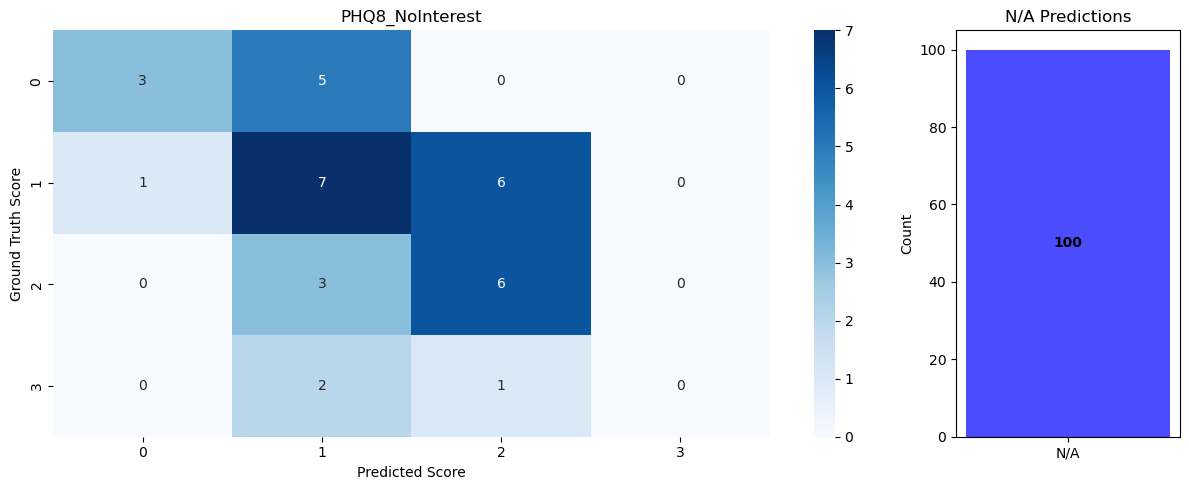

PHQ8_NoInterest Statistics:
  Absolute Average Difference: 0.588
  Number of N/A Questions: 100
  Accuracy on Available Questions: 0.804
  Overall Accuracy: 0.204
--------------------------------------------------


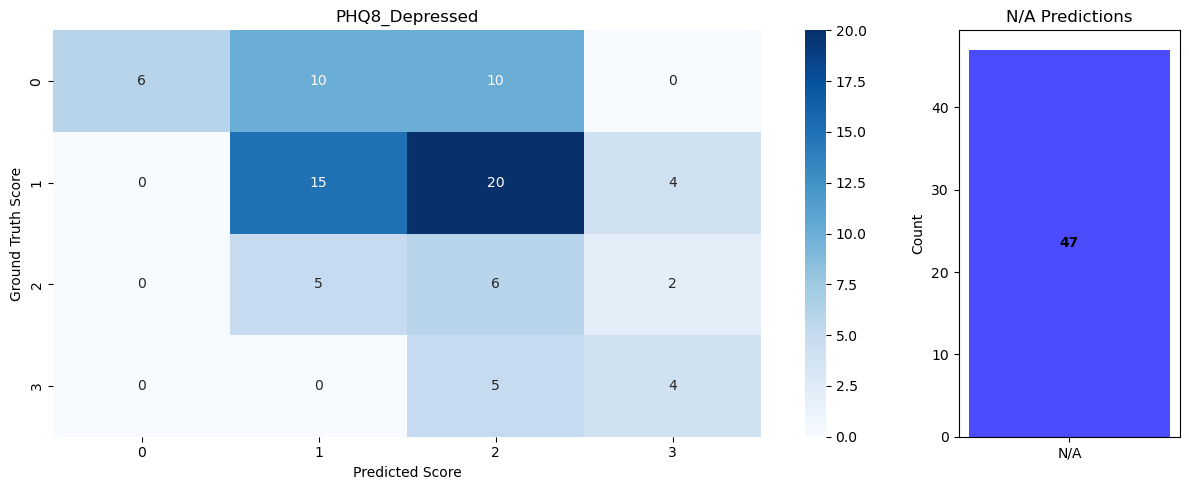

PHQ8_Depressed Statistics:
  Absolute Average Difference: 0.805
  Number of N/A Questions: 47
  Accuracy on Available Questions: 0.732
  Overall Accuracy: 0.475
--------------------------------------------------


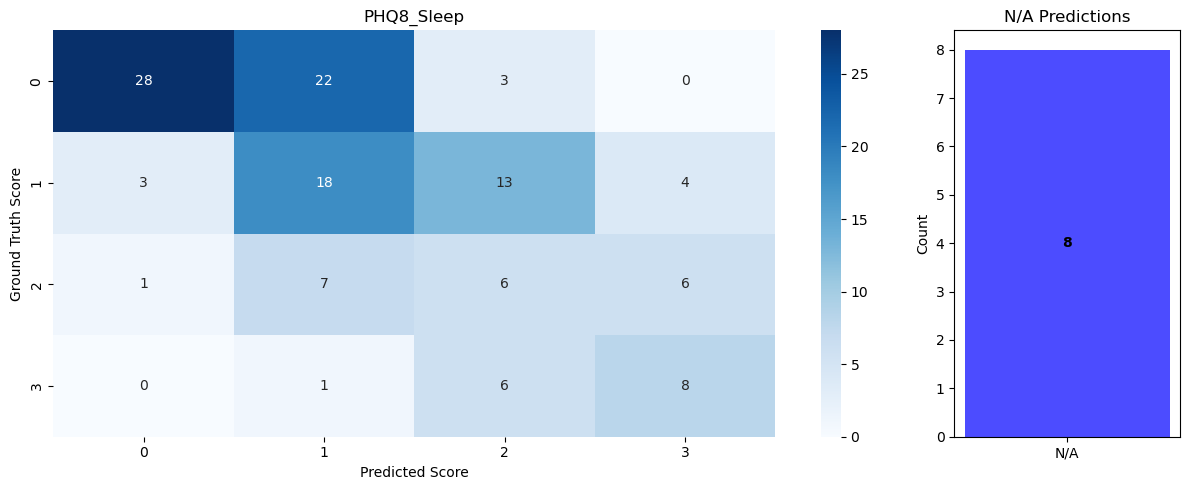

PHQ8_Sleep Statistics:
  Absolute Average Difference: 0.595
  Number of N/A Questions: 8
  Accuracy on Available Questions: 0.802
  Overall Accuracy: 0.754
--------------------------------------------------


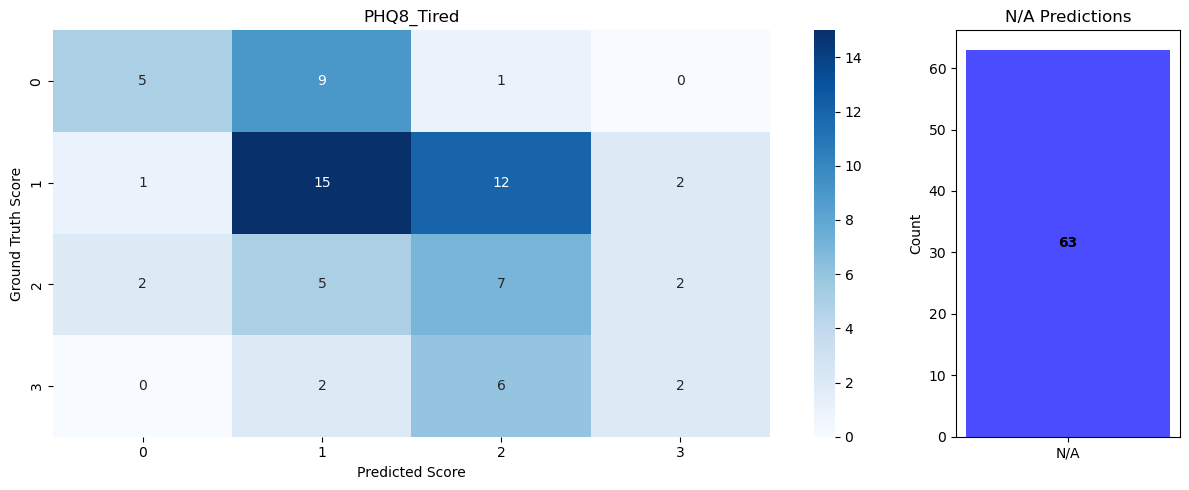

PHQ8_Tired Statistics:
  Absolute Average Difference: 0.690
  Number of N/A Questions: 63
  Accuracy on Available Questions: 0.770
  Overall Accuracy: 0.408
--------------------------------------------------


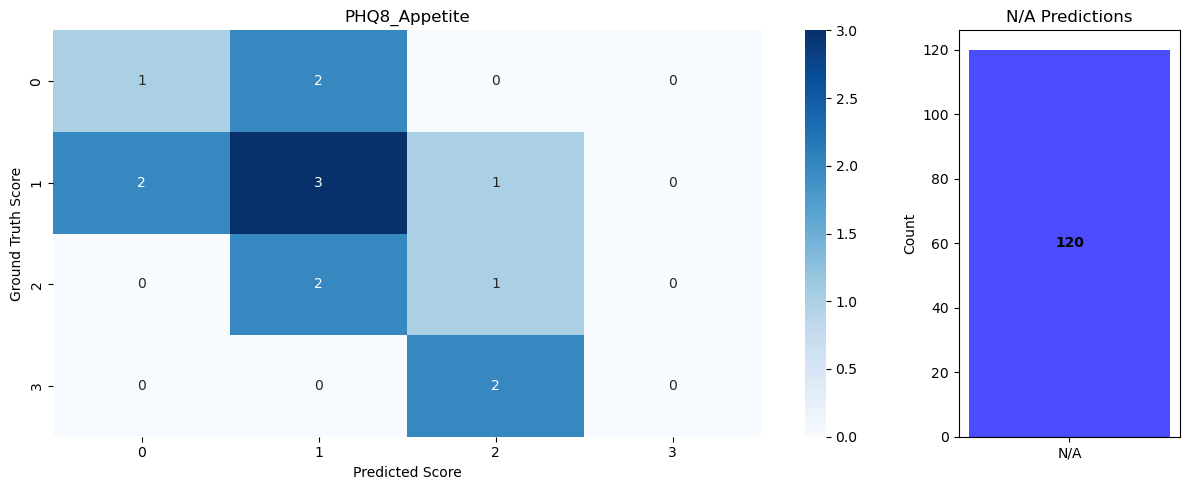

PHQ8_Appetite Statistics:
  Absolute Average Difference: 0.643
  Number of N/A Questions: 120
  Accuracy on Available Questions: 0.786
  Overall Accuracy: 0.082
--------------------------------------------------


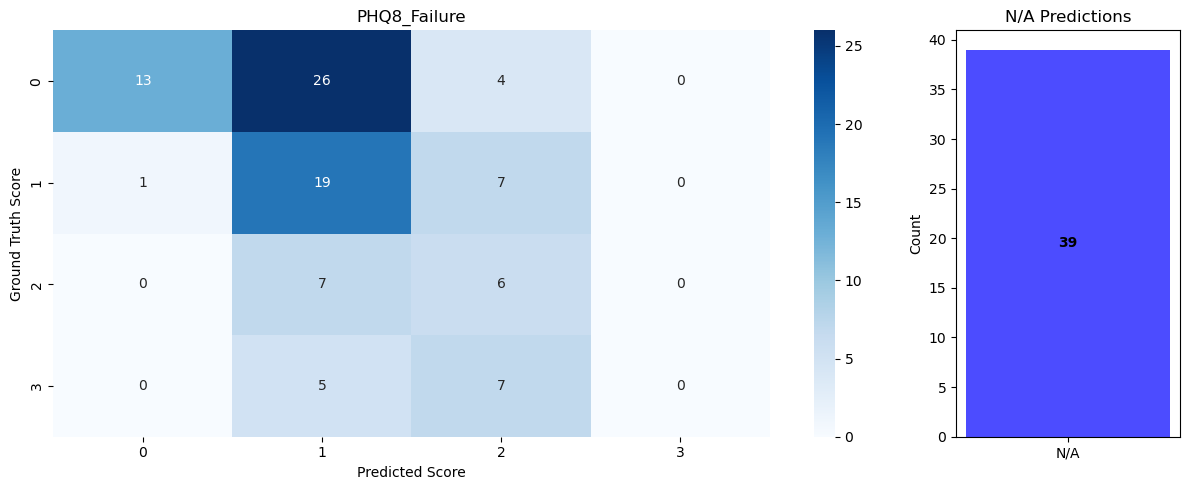

PHQ8_Failure Statistics:
  Absolute Average Difference: 0.695
  Number of N/A Questions: 39
  Accuracy on Available Questions: 0.768
  Overall Accuracy: 0.545
--------------------------------------------------


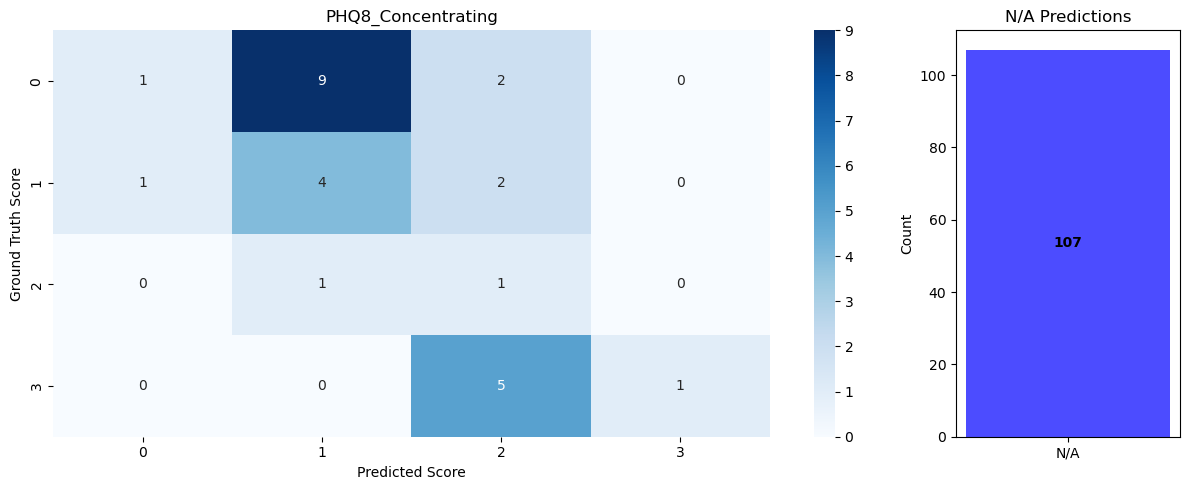

PHQ8_Concentrating Statistics:
  Absolute Average Difference: 0.815
  Number of N/A Questions: 107
  Accuracy on Available Questions: 0.728
  Overall Accuracy: 0.147
--------------------------------------------------


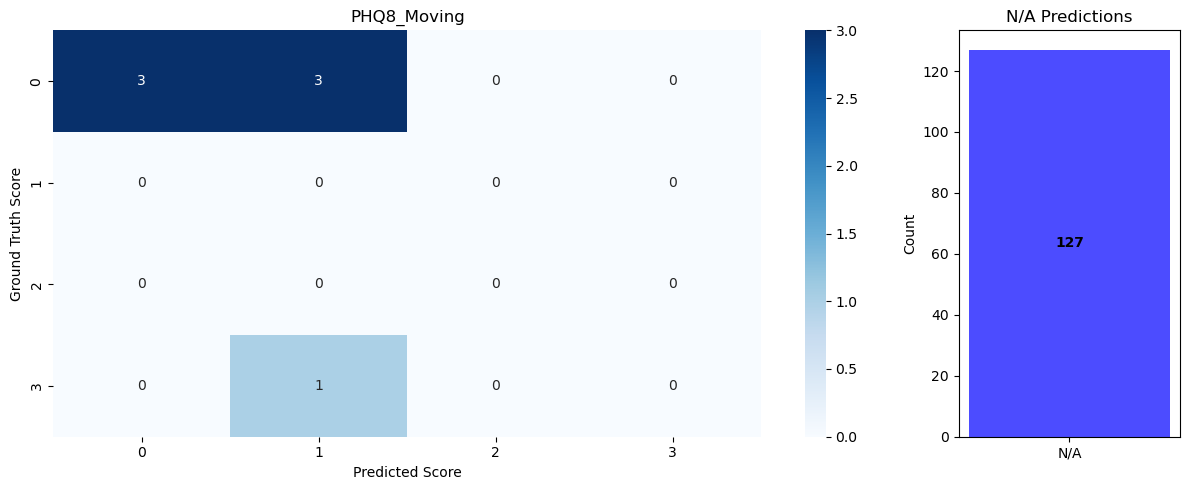

PHQ8_Moving Statistics:
  Absolute Average Difference: 0.714
  Number of N/A Questions: 127
  Accuracy on Available Questions: 0.762
  Overall Accuracy: 0.040
--------------------------------------------------


In [ ]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def load_ground_truth(csv_file1, csv_file2):
    df1 = pd.read_csv(csv_file1)
    df2 = pd.read_csv(csv_file2)
    # Combine the csv files together instead of switching back and forth for participants
    combined_df = pd.concat([df1, df2], ignore_index=True)
    return combined_df

predicted_data = load_jsonl(r"/data/users2/agreene46/ai-psychiatrist/analysis_output/results_detailed.jsonl")
ground_truth_df = load_ground_truth(r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/dev_split_Depression_AVEC2017.csv", r"/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/train_split_Depression_AVEC2017.csv")

# PHQ8 question names
phq8_questions = [
    'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired',
    'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving'
]

def create_heatmap_with_na(predicted_scores, ground_truth_scores, question_name, na_count, participant_data=None):

    # Create confusion matrix
    cm = confusion_matrix(ground_truth_scores, predicted_scores, labels=[0, 1, 2, 3])
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), 
                                   gridspec_kw={'width_ratios': [4, 1]})
    
    # Main heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[0, 1, 2, 3], 
                yticklabels=[3, 2, 1, 0],
                ax=ax1)
    ax1.set_xlabel('Predicted Score')
    ax1.set_ylabel('Ground Truth Score')
    ax1.set_title(question_name)
    
    # N/A count separate display
    ax2.bar(['N/A'], [na_count], color='blue', alpha=0.7)
    ax2.set_ylabel('Count')
    ax2.set_title('N/A Predictions')
    ax2.text(0, na_count/2, str(na_count), ha='center', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    predicted_array = np.array(predicted_scores)
    ground_truth_array = np.array(ground_truth_scores)

    absolute_differences = np.abs(predicted_array - ground_truth_array)
    
    avg_absolute_diff = np.mean(absolute_differences)
    accuracy_available = 1 - (avg_absolute_diff / 3)
    
    total_participants_with_gt = len(predicted_scores) + na_count
    percent_not_na = (total_participants_with_gt - na_count) / total_participants_with_gt
    overall_accuracy = accuracy_available * percent_not_na
    
    # Print statistics
    print(f"{question_name} Statistics:")
    print(f"  Absolute Average Difference: {avg_absolute_diff:.3f}")
    print(f"  Number of N/A Questions: {na_count}")
    print(f"  Accuracy on Available Questions: {accuracy_available:.3f}")
    print(f"  Overall Accuracy: {overall_accuracy:.3f}")
    print("-" * 50)

def extract_scores_for_question(predicted_data, ground_truth_df, question):
    predicted_scores = []
    ground_truth_scores = []
    participant_ids = []
    na_count = 0
    
    for entry in predicted_data:
        participant_id = entry['participant_id']
        
        gt_row = ground_truth_df[ground_truth_df['Participant_ID'] == participant_id]
        
        if not gt_row.empty:
            if question in entry:
                question_data = entry[question]
                score = question_data.get('score', 'N/A')
                
                if score == "N/A":
                    na_count += 1
                    continue
                else:
                    pred_score = int(score)
            else:
                na_count += 1
                continue
            
            # Get ground truth score
            gt_score = gt_row[question].iloc[0]
            
            predicted_scores.append(pred_score)
            ground_truth_scores.append(gt_score)
            participant_ids.append(participant_id)
    
    return predicted_scores, ground_truth_scores, participant_ids, na_count

# Create heatmaps for all PHQ8 questions
for question in phq8_questions:
    predicted_scores, ground_truth_scores, participant_ids, na_count = extract_scores_for_question(
        predicted_data, ground_truth_df, question
    )
    create_heatmap_with_na(predicted_scores, ground_truth_scores, question, na_count)


## Qualitative Assessment

In [5]:
qualitative_prompt = f"""Please analyze the following interview transcript and assess the patient's mental health status, focusing on signs of depression, from social and biological aspects. 

Please provide your assessment in a structured format, including the following sections:
1. Overall Impression in <overall> tags: A brief summary of the patient's mental health status.
2. Social Aspects in <social> tags: Observations related to the patient's interpersonal relationships, family situation, and any relevant social interactions that may influence their mental health.
3. Biological Aspects in <biological> tags: Observations related to the patient's physical health, including sleep quality, appetite, physical activity, stress level, and any other biological factors that may influence their mental health.
4. Additional Notes in <notes> tags: Any other relevant observations or comments that do not fit into the above categories.
5. Potential Risk Factors in <risks> tags: Any identified risk factors for depression or other mental health issues.

Here is the interview transcript:
{patient_transcript}
"""
# Temp, top_k, and top_p set to more deterministic values
response = requests.post(
  BASE_URL,
  json = {
    "model": model,
    "messages": [{"role": "user", "content": qualitative_prompt}],
    "stream": False,
    "options": {
      "temperature": 0,
      "top_k": 20,
      "top_p": 0.9
    }
  }
)

print(json.dumps(response.json(), indent=2))



KeyboardInterrupt: 

## **TESTING ||** Grabbing PHQ-8 related sections from transcript (Using ground truth directly)

In [ ]:
class PHQ8Evidence(BaseModel):
    nointerest_evidence: List[str]
    depressed_evidence: List[str]
    sleep_evidence: List[str]
    tired_evidence: List[str]
    appetite_evidence: List[str]
    failure_evidence: List[str]
    concentrating_evidence: List[str]
    moving_evidence: List[str]

evidence_extraction_prompt = f"""Analyze the following therapy transcript and extract specific text chunks that provide evidence for each PHQ-8 score. For each PHQ-8 domain, find 1-3 relevant quotes from the transcript that best support the given score.

PHQ-8 scoring reference:
- 0 = not at all (0-1 days)
- 1 = several days (2-6 days) 
- 2 = more than half the days (7-11 days)
- 3 = nearly every day (12-14 days)

Given PHQ-8 scores: {train_phq8_dataset.iloc[2]}

For each domain below, extract direct quotes from the transcript that justify the given score. If the score is 0, find evidence showing the absence or minimal presence of that symptom. If the score is higher, find evidence showing the frequency/severity indicated by that score.

PHQ-8 domains:
- nointerest: little interest or pleasure in activities
- depressed: feeling down, depressed, or hopeless
- sleep: sleep problems (trouble falling/staying asleep or sleeping too much)
- tired: feeling tired or having little energy
- appetite: appetite changes (poor appetite or overeating)
- failure: negative self-perception or feeling like a failure
- concentrating: trouble concentrating on tasks
- moving: psychomotor changes (moving/speaking slowly or restlessness)

Return a JSON object with arrays of relevant transcript quotes for each domain. Each quote should be a direct excerpt from the transcript that supports the given score.

Therapy transcript:
{patient_transcript}

Respond with valid JSON matching this structure:
{{
    "nointerest_evidence": ["quote1", "quote2"],
    "depressed_evidence": ["quote1", "quote2"],
    "sleep_evidence": ["quote1", "quote2"],
    "tired_evidence": ["quote1", "quote2"],
    "appetite_evidence": ["quote1", "quote2"],
    "failure_evidence": ["quote1", "quote2"],
    "concentrating_evidence": ["quote1", "quote2"],
    "moving_evidence": ["quote1", "quote2"]
}}

Important: Extract UNIQUE quotes only - do not repeat the same quote multiple times. Each quote should be different and provide distinct evidence.
"""

response = requests.post(
    BASE_URL,
    json={
        "model": model,
        "messages": [{"role": "user", "content": evidence_extraction_prompt}],
        "stream": False,
        "options": {
            "temperature": 0.1,
            "top_k": 10,
            "top_p": 0.8
        }
    }
)

# Printing
response_data = response.json()
content = response_data['message']['content']
content = content.strip('```json\n').strip('\n```')

evidence_dict = json.loads(content)

# Add scores to the output
scores = train_phq8_dataset.iloc[2]
evidence_dict['scores'] = {
    'nointerest': int(scores['PHQ8_NoInterest']),
    'depressed': int(scores['PHQ8_Depressed']),
    'sleep': int(scores['PHQ8_Sleep']),
    'tired': int(scores['PHQ8_Tired']),
    'appetite': int(scores['PHQ8_Appetite']),
    'failure': int(scores['PHQ8_Failure']),
    'concentrating': int(scores['PHQ8_Concentrating']),
    'moving': int(scores['PHQ8_Moving'])
}

# Remove duplicate quotes in each evidence list
for key in evidence_dict:
    if isinstance(evidence_dict[key], list):
        evidence_dict[key] = list(dict.fromkeys(evidence_dict[key]))

formatted_output = json.dumps(evidence_dict, indent=4)
print("!! THIS DOES NOT PREDICT SCORES IT JUST PULLS RELAVENT EVIDENCE FROM THE TRANSCRIPT USING LLM'S !!\n\n")
print(formatted_output)
print(type(formatted_output))

{
    "nointerest_evidence": [
        "I don't like people too much, so being outdoors and uh I've always enjoyed being outdoors that's how I like being a truck driver I've traveled the world.",
        "There's not a lot that I like about l_a but um I like hollywood I like the the movie industry um"
    ],
    "depressed_evidence": [
        "uh I've been diagnosed with uh bipolarism",
        "I just get a lot of racing thoughts so or I get depressed you know 'cause I or I worry about things that you know that really I have no control over"
    ],
    "sleep_evidence": [
        "It's been hard lately it's been probably hard for the last uh going on a year um you know I uh depending on my thought process at the time I like I said I've been looking for work quite a bit um so just wondering why you know I don't get called I I just have my I have racing thoughts",
        "lately I have been probably about the last few months"
    ],
    "tired_evidence": [
        "lately I've been sl

### Original ollama example script (for reference)

In [3]:
"""Available models:
- gemma3-optimized:27b
- gemma3_optimized:8bit
- gemma3:27b-it-qat
- gemma3:27b
- phi4-optimized:latest
- phi4:latest
- phi4-reasoning:plus
- qwen3_optimized:latest
- qwen3:32b
- llama3.3:latest
- llama4:scout
- mistral3.1-optimized:latest
- mistral-small3.1:latest
- qwq:latest

Notes:
1. The models marked as "optimized" are configured to use multiple GPUs for faster inference.
2. The llama4:maverick model is not available due to its size.
"""

OLLAMA_NODE = "arctrddgxa002" # TODO: Change this variable to the node where Ollama is running
BASE_URL = f"http://{OLLAMA_NODE}:11434/api/chat"

model = "qwq:latest" # TODO: Change this variable to the model you want to use
message = "What is the capital of France?" # TODO: Change this variable to the message you want to ask the model

response = requests.post(
  BASE_URL,
  json = {
    "model": model,
    "messages": [{"role": "user", "content": message}],
    "stream": False
  }
)

print(json.dumps(response.json(), indent=2))

{
  "model": "qwq:latest",
  "created_at": "2025-07-15T22:46:58.150903388Z",
  "message": {
    "role": "assistant",
    "content": "<think>\nOkay, the user is asking, \"What is the capital of France?\" Let me think about how to approach this.\n\nFirst, I need to confirm the correct answer. The capital of France is Paris. That's a well-known fact, but I should make sure there hasn't been any recent changes, which is unlikely. \n\nNext, I should consider why the user is asking this. It might be a straightforward question for someone learning basic geography. Alternatively, they could be testing the system's knowledge. Either way, the answer needs to be clear and accurate.\n\nI should also think about providing a bit more context. Maybe mention that Paris is not only the capital but also the most populous city in France. Including some landmarks like the Eiffel Tower or the Louvre could add value. But wait, the user didn't ask for extra details, so maybe keep it concise unless they ask f